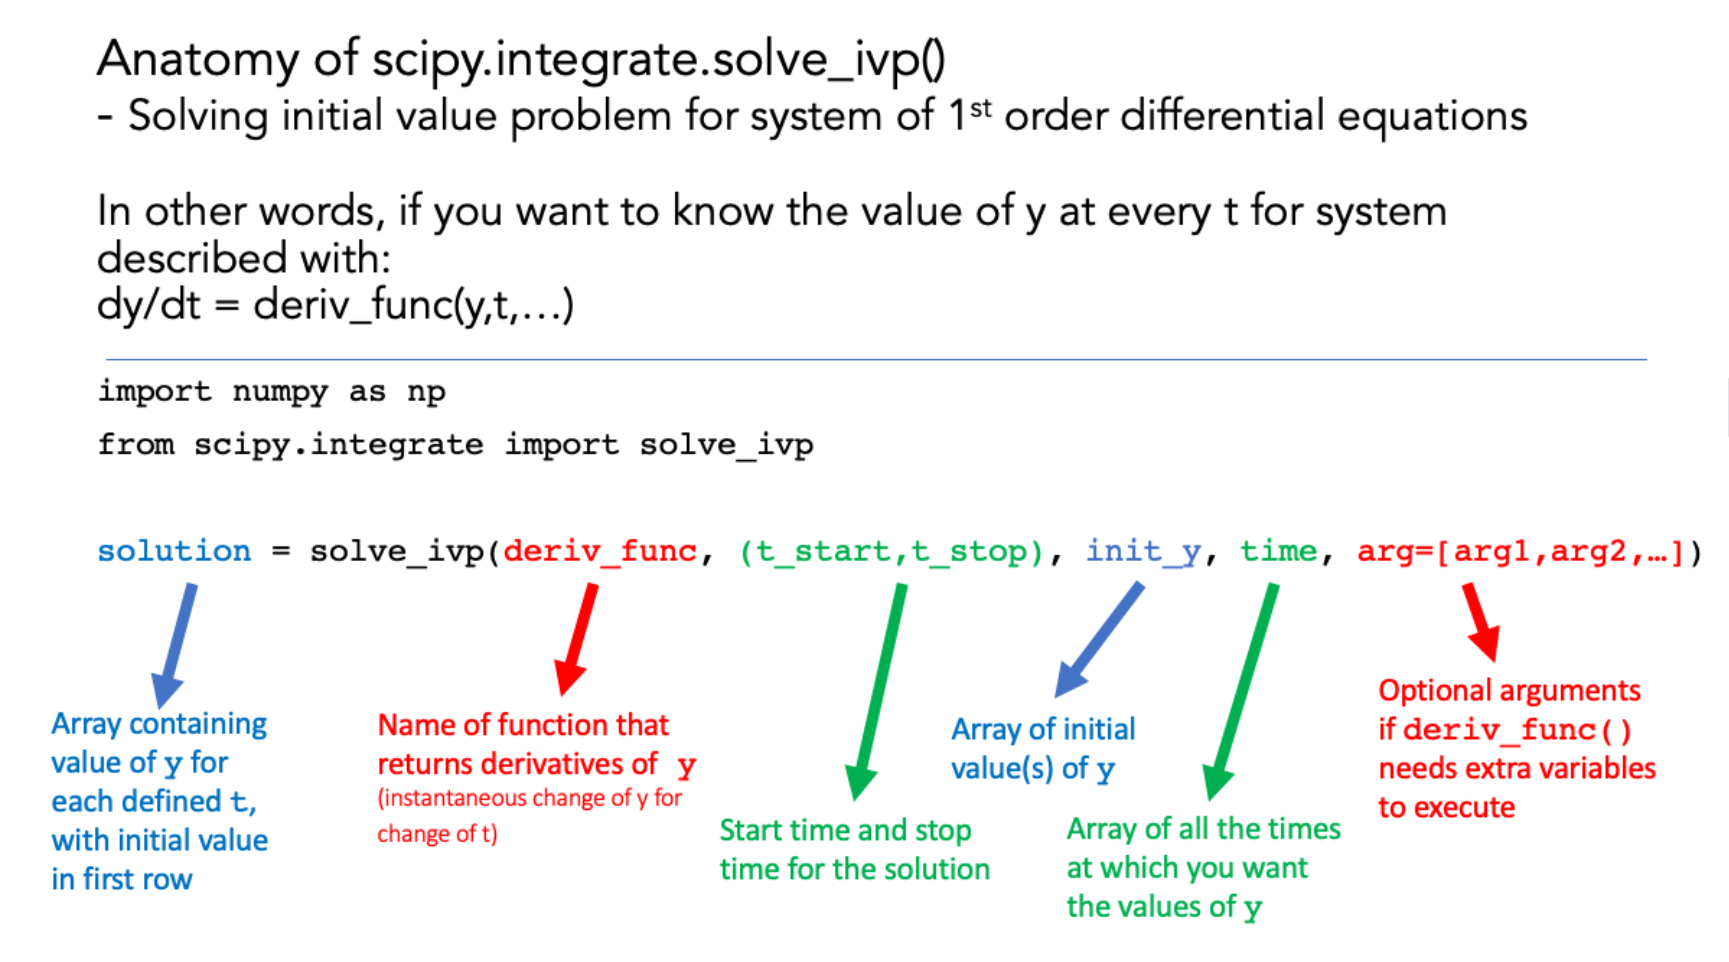

$$
\begin{aligned}
     \frac{d S}{d t}  & = - \beta \, S \,  \frac{I}{N}
     \\
     \frac{d E}{d t}   & = \beta \, S \,   \frac{I}{N}  - \sigma E
     \\
      \frac{d I}{d t}  & = \sigma  E  - \gamma I
     \\
      \frac{d R}{d t}  & = \gamma  I
\end{aligned} \tag{44.1}
$$

just take the log of the thing to transform

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

# Note that the SciPy library is needed for solve_ivp
from scipy.integrate import solve_ivp

In [5]:
# STEP 2: define the function that contains the derivatives
def derivs(t, curr_vals, gamma = 1/18, R_0 = 3.0, model_sigma = 1/5.2):

    S,E,I,r = curr_vals
    
    dSdt = -gamma * R_0 * S * I

    dEdt = gamma * R_0 * S * I - model_sigma * E

    dIdt = model_sigma * E - gamma * I

    drdt = gamma * I

    return dSdt,dEdt,dIdt,drdt


I_0 = 1e-7
E_0 = 4.0 * I_0
S_0 = 1.0 - I_0 
r_0 = 0.0
x_0 = [S_0,E_0,I_0,r_0]


# STEP 4: add time array here

tmax = 350
dt = 0.1
t = np.arange(0,tmax+dt,dt)

gamma = 1/18
R_0 = 3.0
model_sigma = 1/5.2
true_values = (gamma, R_0, model_sigma)

solved = solve_ivp(derivs,(0,tmax),x_0,t_eval = t, args = (gamma,R_0,model_sigma))

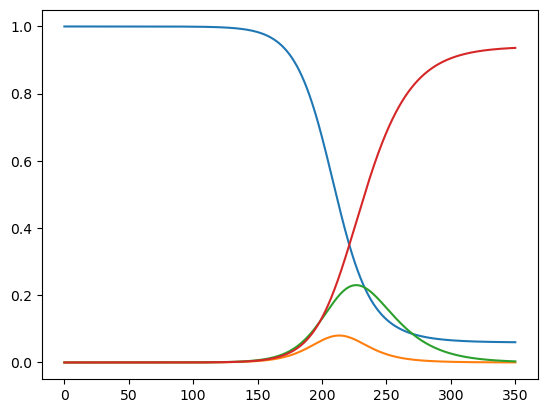

In [6]:
plt.plot(t,solved.y[0])
plt.plot(t,solved.y[1])
plt.plot(t,solved.y[2])
plt.plot(t,solved.y[3])
plt.show()

In [7]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

In [8]:
D = 3
sigma = 0.1
y_true = solved.y
print('true values:',true_values)

def log_likelihood(theta):
    gamma_log,R_0,model_sigma_log = theta

    gamma = np.exp(gamma_log)
    model_sigma = np.exp(model_sigma_log)
    sol = solve_ivp(derivs,(0,tmax),x_0,t_eval = t, args = (gamma,R_0,model_sigma))
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5))-(0.5/sigma**2) * (y_true - sol.y)**2)

print(log_likelihood(true_values))

true values: (0.05555555555555555, 3.0, 0.1923076923076923)
-145921.55114668253


: 

In [36]:
print(np.array([np.log(gamma),R_0,np.log(model_sigma)]))

[-2.89037176  3.         -1.64865863]


In [26]:
LB = np.full((1, D), -10)  # Lower bounds
UB = np.full((1, D), 1.1)  # Upper bounds
LB[0][1] = 0.0
UB[0][1] = 100


# LB = np.full((1, D), -np.inf)  # Lower bounds
# UB = np.full((1, D), np.inf)  # Upper bounds

PLB = np.full((1, D), -9.0)
PLB[0][1] = 0.5
PUB = np.full((1, D), 1.0)
PUB[0][1] = 10

x0 = np.array([[-3,2,-1]])

prior = SplineTrapezoidal(LB, PLB, PUB, UB)

options = {
    "max_fun_evals": 500
}

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0:',x0) # I hate this
print(LB < PLB)
print(PLB< PUB)
print(PUB < UB)

LB: [[-10   0 -10]] PLB: [[-9.   0.5 -9. ]] PUB: [[ 1. 10.  1.]] UB: [[  1.1 100.    1.1]] x0: [[-3  2 -1]]
[[ True  True  True]]
[[ True  True  True]]
[[ True  True  True]]


In [27]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior,options = options) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Casting initial points to floating point.
Casting lower bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10      -40427.37     21917.78          inf        2        inf     start warm-up
     1         15        9909.66     16877.80   4361713.38        2        inf     
     2         20        6034.07      5935.20     33281.94        2   6.73e+05     
     3         25      -12924.89     12802.56  31872225.38        2   6.13e+08     
     4         30       -6758.11      3678.82     40945.35        2   8.21e+05     
     5         35       16529.06      3350.21     25145.14        2   5.73e+05     
     6         40       16119.64      3770.71     15476.34        2   3.12e+05     
     7         45       16280.93      3606.03      7219.43        2   1.51e+05     
     8         50       14098.03      4621.00   6911928.81        2   1.33e+08     
     9         55       11272.89      3616.43      1921.17        2   5.84e+04     
    10         60       12316.70       218.18      4363.75        2   8.82e+04     
    11         65       13478.69       297.13      3022.05     

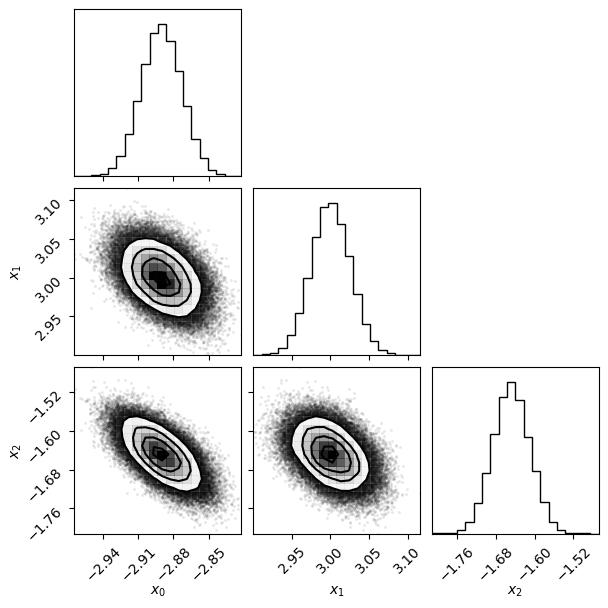

In [28]:
vp.plot();

In [3]:
moments = vp.moments()

In [32]:
print(moments,np.exp(moments),[gamma,R_0,model_sigma])

[[-2.89037952  3.0004765  -1.64842102]] [[ 0.05555512 20.09510996  0.19235339]] [0.05555555555555555, 3.0, 0.1923076923076923]


In [34]:
vp.save("3d_vp_reasonable.pkl")

In [2]:
from pyvbmc import VariationalPosterior
vp = VariationalPosterior.load("3d_vp_reasonable.pkl")

In [ ]:
truth = np.array([])